In [1]:
import torch
import numpy as np
from itertools import islice

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, write_jpeg, decode_image
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop
from torcheval import metrics

from PIL import Image
import scipy.io as scio
import matplotlib.pyplot as plt
import pickle

In [2]:
emotions = np.array(['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
                     'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
                     'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning'])

emotion_encode = {e: i for i, e in enumerate(emotions)}
emotion_decode = {i: e for e, i in emotion_encode.items()}

In [3]:
class EmoticDataset(Dataset):
    def __init__(self, data_type, subject_size, context_size, anns_dir, img_dir, alex=False):
        anns = scio.loadmat(anns_dir)[data_type]
        # self.anns = np.fromiter(filter(lambda x: x["folder"].item() != "framesdb/images", iter(anns[0])), dtype=anns.dtype)
        self.anns = anns[0]
        
        self.data_idx = list()
        for i, ann in enumerate(self.anns):
            for p in range(len(ann["person"][0])):
                self.data_idx.append([i, p])
        
        self.img_dir = img_dir
        self.context_process = transforms.ToTensor()
        self.subject_transform = transforms.Resize(subject_size)

        if alex:
            self.context_transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.CenterCrop(224),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
        else:
            self.context_transform = transforms.Resize(context_size)

    def __len__(self):
        return len(self.data_idx)

    def __getitem__(self, idx):
        ann_idx, p_idx = self.data_idx[idx]
        ann = self.anns[ann_idx]

        img_loc = "../data/pami/emotic/" + ann["folder"].item() + '/' + ann["filename"].item()
        # context_img = read_image(img_loc)
        context_img = Image.open(img_loc)
        context_img = (self.context_process(context_img) * 255).to(torch.uint8)
        
        if context_img.shape[0] == 1:
            context_img = context_img.repeat(3, 1, 1)

        if context_img.shape[0] > 3:
            context_img = context_img[:3]
        
        bbox = ann["person"]["body_bbox"][0][p_idx][0].astype(int)
        subject_img = crop(context_img, bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0])

        label = np.zeros(len(emotions), dtype=np.float32)
        ems = [i.item() for i in ann["person"]["annotations_categories"][0][0][0][0][0][0]]
        for e in ems:
            label[emotion_encode[e]] = 1.
            
        subject_img = self.subject_transform(subject_img.float())
        context_img = self.context_transform(context_img.float())

        return subject_img, context_img, label

In [4]:
def net_branch():
    return nn.Sequential(
        nn.Conv2d(3, 96, (11, 1), stride=(4, 1)),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.Conv2d(96, 96, (1, 11), stride=(1, 4)),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2),
        
        nn.Conv2d(96, 256, (1, 5), padding="same"),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, (5, 1), padding="same"),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2),
        
        nn.Conv2d(256, 384, (1, 3), padding="same"),
        nn.BatchNorm2d(384),
        nn.ReLU(),
        nn.Conv2d(384, 384, (3, 1), padding="same"),
        nn.BatchNorm2d(384),
        nn.ReLU(),
        
        nn.Conv2d(384, 384, (1, 3), padding="same"),
        nn.BatchNorm2d(384),
        nn.ReLU(),
        nn.Conv2d(384, 384, (3, 1), padding="same"),
        nn.BatchNorm2d(384),
        nn.ReLU(),
        
        nn.Conv2d(384, 256, (1, 3), padding="same"),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, (3, 1), padding="same"),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(3, stride=2)
    )

In [5]:
def alex_branch():
    return nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
        nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.subject = net_branch()
        self.context = net_branch()
        
        self.fusion = nn.Sequential(
            nn.Linear(12800, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, len(emotions)),
            nn.Sigmoid()
        )

    def forward(self, s, c):
        s = self.subject(s)
        s = torch.flatten(s, start_dim=1)
        
        c = self.context(c)
        c = torch.flatten(c, start_dim=1)

        x = torch.cat((s, c), dim=1)
        x = self.fusion(x)
        return x

In [88]:
class PretrainedNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.subject = net_branch()
        self.context = alex_branch()

        alexnet_file = "../models/alexnet_places365.pth.tar"
        checkpoint = torch.load(alexnet_file, map_location=lambda storage, loc: storage, weights_only=False)
        state_dict = {str.replace(k,'features.module.',''): v for k, v in checkpoint['state_dict'].items() if "features" in k}

        # context = models.__dict__["alexnet"](num_classes=365)
        self.context.load_state_dict(state_dict)

        for param in islice(self.context.parameters(), 4):
            param.requires_grad = False
        
        self.fusion = nn.Sequential(
            nn.Linear(15616, 256),
            # nn.Linear(6400, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, len(emotions)),
            nn.Sigmoid()
        )

    def forward(self, s, c):
        s = self.subject(s)
        s = torch.flatten(s, start_dim=1)
        
        c = self.context(c)
        c = torch.flatten(c, start_dim=1)

        x = torch.cat((s, c), dim=1)
        x = self.fusion(x)
        return x

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [9]:
subject_size = (224, 224)
context_size = (224, 224)

train_batch_size = 52
val_batch_size = 52
test_batch_size = 52
num_epochs = 500
learning_rate = 1e-4

In [53]:
alex_data = True

train_data = EmoticDataset("train", subject_size, context_size, "../data/pami/Annotations/Annotations.mat", "../data/pami/emotic/", alex=alex_data)
train_dataloader = DataLoader(train_data, batch_size=train_batch_size)

val_data = EmoticDataset("val", subject_size, context_size, "../data/pami/Annotations/Annotations.mat", "../data/pami/emotic/", alex=alex_data)
val_dataloader = DataLoader(val_data, batch_size=val_batch_size)

test_data = EmoticDataset("test", subject_size, context_size, "../data/pami/Annotations/Annotations.mat", "../data/pami/emotic/", alex=alex_data)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size)

train_size = len(train_dataloader.dataset)
val_size = len(val_dataloader.dataset)
test_size = len(test_dataloader.dataset)

In [89]:
bce = nn.BCELoss(reduction="none")

def loss_fn(pred, y):
    counts = y.sum(dim=0)
    probs = counts / counts.sum()
    weights = 1 / torch.log(1.1 + probs)

    return (bce(pred, y) * weights).mean()

In [90]:
metric = metrics.MultilabelAUPRC(num_labels=len(emotions), device=device)

In [91]:
# emotic_net = Net().to(device)

emotic_net = PretrainedNet().to(device)

In [94]:
sum(np.prod(i.data.shape) for i in emotic_net.parameters() if i.requires_grad)

np.int64(9103674)

In [15]:
p_idx = 32

for i, p in enumerate(emotic_net.parameters()):
    if i == p_idx:
        sample_param = p
        break

In [16]:
# optimizer = torch.optim.SGD(emotic_net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(emotic_net.parameters(), lr=learning_rate)

In [17]:
sample_param.view(-1)[0].item()

-0.018264038488268852

In [18]:
optimizer.param_groups[0]["params"][p_idx].view(-1)[0].item()

-0.018264038488268852

In [19]:
pt = 20

train_history = list()
val_history = list()
test_history = list()

pt_count = 0
mt_max = 0
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    emotic_net.train()
    for batch, (S, C, y) in enumerate(train_dataloader):
        S, C, y = S.to(device), C.to(device), y.to(device)
        pred = emotic_net(S, C)
        loss = loss_fn(pred, y)
    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss, current = loss.item(), min((batch + 1) * train_batch_size, train_size)
        print(f"loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}] ; sample param: {sample_param.view(-1)[0].item():>7f}    ", end="\r")
        # print(f"grad: {sample_param.grad.view(-1)[0].item():>7f}")
        
    print()
    
    metric.reset()
    emotic_net.eval()
    for batch, (S, C, y) in enumerate(train_dataloader):
        with torch.no_grad():
            S, C, y = S.to(device), C.to(device), y.to(device)
            pred = emotic_net(S, C)
            metric.update(pred, y)
    
            current = min((batch + 1) * train_batch_size, train_size)
            print(f"calculating train metric for:  [{current:>4d}/{train_size:>4d}]", end="\r")

    mt = metric.compute()
    train_history.append(mt)
    
    print()
    print(f"train metric: {mt * 100:>7f} %\n")
    
    metric.reset()
    emotic_net.eval()
    for batch, (S, C, y) in enumerate(val_dataloader):
        with torch.no_grad():
            S, C, y = S.to(device), C.to(device), y.to(device)
            pred = emotic_net(S, C)
            metric.update(pred, y)
    
            current = min((batch + 1) * val_batch_size, val_size)
            print(f"calculating validation metric for:  [{current:>4d}/{val_size:>4d}]", end="\r")
    
    mt = metric.compute()
    if mt > mt_max:
        mt_max = mt
        torch.save(emotic_net.state_dict(), "../models/pretrained_freeze_history.pth")
    else:
        pt_count += 1
        if pt_count > pt:
            break

    val_history.append(mt)
    
    print()
    print(f"val metric: {mt * 100:>7f} %\n")
    
    metric.reset()
    emotic_net.eval()
    for batch, (S, C, y) in enumerate(test_dataloader):
        with torch.no_grad():
            S, C, y = S.to(device), C.to(device), y.to(device)
            pred = emotic_net(S, C)
            metric.update(pred, y)
    
            current = min((batch + 1) * test_batch_size, test_size)
            print(f"calculating test metric for:  [{current:>4d}/{test_size:>4d}]", end="\r")
            
    mt = metric.compute()
    test_history.append(mt)
    
    print()
    print(f"test metric: {mt * 100:>7f} %\n")

Epoch 1/500
loss: 1.327145  [23706/23706] ; sample param: -0.016175      
calculating train metric for:  [23706/23706]
train metric: 11.230634 %

calculating validation metric for:  [3334/3334]
val metric: 12.132594 %

calculating test metric for:  [7280/7280]
test metric: 12.102367 %

Epoch 2/500
loss: 1.321828  [23706/23706] ; sample param: -0.014399    
calculating train metric for:  [23706/23706]
train metric: 13.468297 %

calculating validation metric for:  [3334/3334]
val metric: 13.390939 %

calculating test metric for:  [7280/7280]
test metric: 12.382704 %

Epoch 3/500
loss: 1.301854  [23706/23706] ; sample param: -0.014629    
calculating train metric for:  [23706/23706]
train metric: 16.988085 %

calculating validation metric for:  [3334/3334]
val metric: 14.884753 %

calculating test metric for:  [7280/7280]
test metric: 12.085972 %

Epoch 4/500
loss: 1.257249  [23706/23706] ; sample param: -0.014939    
calculating train metric for:  [23706/23706]
train metric: 22.075035 %


In [43]:
train_h = [h.item() for h in train_history]
val_h = [h.item() for h in val_history]

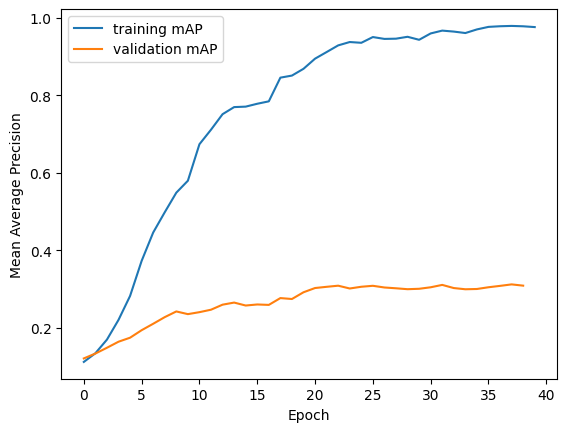

In [57]:
plt.plot(train_h, label="training mAP")
plt.plot(val_h, label="validation mAP")
plt.xlabel("Epoch")
plt.ylabel("Mean Average Precision")
plt.legend()
plt.savefig("../plots/training_curve.png")
# plt.show()

In [48]:
with open("../plots/train_history.pkl", "wb") as f:
    pickle.dump(train_h, f)
    
with open("../plots/val_history.pkl", "wb") as f:
    pickle.dump(val_h, f)

In [49]:
with open("../plots/train_history.pkl", "rb") as f:
    train_h_load = pickle.load(f)
    
with open("../plots/val_history.pkl", "rb") as f:
    val_h_load = pickle.load(f)

In [99]:
load_emotic_net = PretrainedNet().to(device)
load_emotic_net.load_state_dict(torch.load("../models/pretrained_freeze_2.pth", weights_only=True))

<All keys matched successfully>

In [100]:
def compute_metrics(emotic_net, metric, dataloader, batch_size, size):
    metric.reset()
    emotic_net.eval()
    for batch, (S, C, y) in enumerate(dataloader):
        with torch.no_grad():
            S, C, y = S.to(device), C.to(device), y.to(device)
            pred = emotic_net(S, C)
            metric.update(pred, y)
    
            current = min((batch + 1) * batch_size, size)
            print(f"calculating metric for:  [{current:>4d}/{size:>4d}]", end="\r")
    
    print()
    return metric.compute()

In [27]:
mets = compute_metrics(load_emotic_net, metric, train_dataloader, train_batch_size, train_size)
print(f"metric: {mets * 100} %")

calculating metric for:  [7280/7280]
metric: 11.307531356811523 %


In [101]:
mets = compute_metrics(load_emotic_net, metric, val_dataloader, val_batch_size, val_size)
print(f"metric: {mets * 100} %")

calculating metric for:  [3334/3334]
metric: 31.06916046142578 %


In [103]:
class_metrics = compute_metrics(load_emotic_net, metrics.MultilabelAUPRC(num_labels=len(emotions), device=device, average=None), val_dataloader, val_batch_size, val_size)

for e, m in zip(emotions, class_metrics):
    print(f"{e:16}: {m*100:>6.3f} %")

calculating metric for:  [3334/3334]
Affection       : 33.355 %
Anger           : 16.360 %
Annoyance       :  6.880 %
Anticipation    : 51.445 %
Aversion        : 28.778 %
Confidence      : 46.687 %
Disapproval     : 17.657 %
Disconnection   : 38.314 %
Disquietment    : 22.141 %
Doubt/Confusion : 38.336 %
Embarrassment   : 32.747 %
Engagement      : 75.752 %
Esteem          : 24.973 %
Excitement      : 45.285 %
Fatigue         : 11.526 %
Fear            : 24.031 %
Happiness       : 59.527 %
Pain            : 15.059 %
Peace           : 44.992 %
Pleasure        : 48.138 %
Sadness         : 28.494 %
Sensitivity     : 12.930 %
Suffering       : 12.191 %
Surprise        : 40.767 %
Sympathy        : 15.382 %
Yearning        : 16.051 %


In [114]:
for e, m in sorted(zip(emotions, class_metrics), key=lambda x: -x[1]):
    print(f"{e:16}: {m*100:>6.3f} %")

Engagement      : 75.752 %
Happiness       : 59.527 %
Anticipation    : 51.445 %
Pleasure        : 48.138 %
Confidence      : 46.687 %
Excitement      : 45.285 %
Peace           : 44.992 %
Surprise        : 40.767 %
Doubt/Confusion : 38.336 %
Disconnection   : 38.314 %
Affection       : 33.355 %
Embarrassment   : 32.747 %
Aversion        : 28.778 %
Sadness         : 28.494 %
Esteem          : 24.973 %
Fear            : 24.031 %
Disquietment    : 22.141 %
Disapproval     : 17.657 %
Anger           : 16.360 %
Yearning        : 16.051 %
Sympathy        : 15.382 %
Pain            : 15.059 %
Sensitivity     : 12.930 %
Suffering       : 12.191 %
Fatigue         : 11.526 %
Annoyance       :  6.880 %


In [74]:
e_count = np.zeros(len(emotions))
for t in train_data:
    e_count += t[2]

In [86]:
e_count / e_count.sum() * 100

array([ 2.3467103 ,  0.48871857,  0.83534275, 11.58930417,  0.40260076,
        8.97347571,  0.77075439,  3.2940062 ,  1.12599035,  1.48768515,
        0.31433   , 28.01627627,  1.80847399,  9.6107475 ,  1.13890803,
        0.38107131, 12.42249397,  0.39614192,  3.65354805,  4.60730279,
        0.89562522,  0.79228384,  0.5856011 ,  0.96021357,  1.67283844,
        1.42955563])

In [113]:
for i, ((e, c), m) in enumerate(zip(zip(emotions, e_count), class_metrics)):
    print(f" \hline {i+1} & {e} & {int(c)} & {m*100:.3f} \% \\\\")

 \hline 1 & Affection & 1090 & 33.355 \% \\
 \hline 2 & Anger & 227 & 16.360 \% \\
 \hline 3 & Annoyance & 388 & 6.880 \% \\
 \hline 4 & Anticipation & 5383 & 51.445 \% \\
 \hline 5 & Aversion & 187 & 28.778 \% \\
 \hline 6 & Confidence & 4168 & 46.687 \% \\
 \hline 7 & Disapproval & 358 & 17.657 \% \\
 \hline 8 & Disconnection & 1530 & 38.314 \% \\
 \hline 9 & Disquietment & 523 & 22.141 \% \\
 \hline 10 & Doubt/Confusion & 691 & 38.336 \% \\
 \hline 11 & Embarrassment & 146 & 32.747 \% \\
 \hline 12 & Engagement & 13013 & 75.752 \% \\
 \hline 13 & Esteem & 840 & 24.973 \% \\
 \hline 14 & Excitement & 4464 & 45.285 \% \\
 \hline 15 & Fatigue & 529 & 11.526 \% \\
 \hline 16 & Fear & 177 & 24.031 \% \\
 \hline 17 & Happiness & 5770 & 59.527 \% \\
 \hline 18 & Pain & 184 & 15.059 \% \\
 \hline 19 & Peace & 1697 & 44.992 \% \\
 \hline 20 & Pleasure & 2140 & 48.138 \% \\
 \hline 21 & Sadness & 416 & 28.494 \% \\
 \hline 22 & Sensitivity & 368 & 12.930 \% \\
 \hline 23 & Suffering & 272 & 1

In [51]:
idx = 633
data = train_data[idx]
data = (data[0].unsqueeze(0), data[1].unsqueeze(0), torch.tensor(data[2]).unsqueeze(0))

In [37]:
out = emotic_net(data[0].to(device), data[1].to(device))

In [46]:
out[1].shape

torch.Size([1, 256, 6, 6])

In [33]:
loss_fn(out, data[2].to(device))

tensor(0.5061, device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
emotions[out.cpu()[0] > 0.5]

array(['Anticipation', 'Engagement'], dtype='<U15')

In [35]:
emotions[data[2][0] > 0.5]

array(['Anticipation'], dtype='<U15')